In [11]:
import mysql.connector

# returns connection object #
def connect_to_db(db_name):
    cnx = mysql.connector.connect(
    user='root',
    password='chalkHorseMountain',
    host='localhost',
    database=db_name
    )
    return cnx

# returns boolean #
def table_exists(cursor, tbl_name):
    cursor.execute("""
        SELECT COUNT(*)
        FROM information_schema.tables
        WHERE table_schema = DATABASE()
        AND table_name = \"""" + tbl_name + """\";
    """)
    
    if cursor.fetchone()[0] == 1:
        return True
    return False

In [31]:
cnx = connect_to_db("TheSpatula")
mycursor = cnx.cursor()
assert mycursor
assert table_exists(mycursor, "reddit")

mycursor.execute("""
    SELECT num_votes, num_comments, date_posted
    FROM reddit
    WHERE symbol="TSLA"
    AND date_posted > "2021-01-01"
    ;
    """)

votes = list()
comments = list()
dates = list()

for (num_votes, num_comments, date_posted) in mycursor:
    votes.append(num_votes)
    comments.append(num_comments)
    dates.append(date_posted)

mycursor.close()
cnx.close()

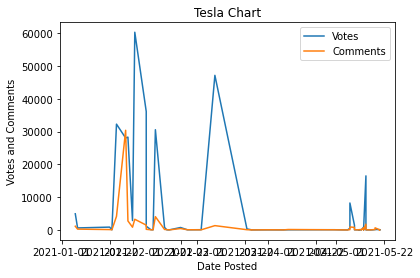

In [32]:
from matplotlib import pyplot as plt

x = dates
y = votes
z = comments
plt.plot(x,y)
plt.plot(x,z)
plt.title("Tesla Chart")
plt.xlabel("Date Posted")
plt.ylabel("Votes and Comments")
plt.legend(["Votes", "Comments"])
plt.show()

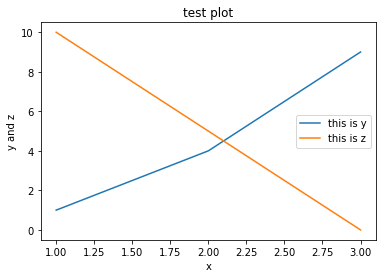

In [28]:
from matplotlib import pyplot as plt

x = [1, 2, 3]
y = [1, 4, 9]
z = [10, 5, 0]
plt.plot(x,y)
plt.plot(x,z)
plt.title("test plot")
plt.xlabel("x")
plt.ylabel("y and z")
plt.legend(["this is y", "this is z"])
plt.show()